# Implementation
- 

# 1 - Import required libraries and load data

- same as Logistic regression since we're using the same dataset

In [11]:
# --- Imports ---
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix


# --- Load and Prepare Data ---
data = load_breast_cancer()
df = pd.DataFrame(data.data, columns=data.feature_names)
df['Diagnosis'] = pd.Series(data.target).map({0: 'Malignant', 1: 'Benign'})

print(df.head())
print("Shape:", df.shape)

print(df['Diagnosis'].value_counts())

   mean radius  mean texture  mean perimeter  mean area  mean smoothness  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   mean compactness  mean concavity  mean concave points  mean symmetry  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   mean fractal dimension  ...  worst texture  worst perimeter  worst area  \
0             

# 2 - Initial screening for variables

- Here we will calculate and plot each of the independent variable against diagnosis to see which were most impactful to diagnosis

- We also note that KKN models are similarly sensitive to outliers due to it being distance based, so we would want to select those without noticable outliers.


In [ ]:
# --- Output Mean and SE by Diagnosis ---
print("=== Mean and Standard Error by Diagnosis ===\n")
mean_se = df.groupby('Diagnosis').agg(['mean', 'sem']).T
display(mean_se)

# 2.1 - visualization of unfiltered attributes
- we will plot each feature against the dependent variable to identify which were the most distinct for the different diagnosis.

In [ ]:
# --- Plot Histograms by Diagnosis ---
for feature in data.feature_names:
    plt.figure(figsize=(6, 4))
    sns.histplot(data=df, x=feature, hue='Diagnosis', bins=30, kde=True, element='step', stat='density')
    plt.title(f'Distribution of {feature}')
    plt.tight_layout()
    plt.show()

** Remarks **

- Just as in logistic regression, we identify radius, mean perimeter, mean area, mean concavity as our selected attributes to continue. I did not include mean concave point as i want this model to be implemented differently from the logistic model to see how they differ. 

- We will create a Correlation Matrix of the attributes to check for their correlation with each other.

# 2.2 - Correlation heatmap of unfiltered attributes
- Here we create a correlation matrix showing each attributes' correlation with other

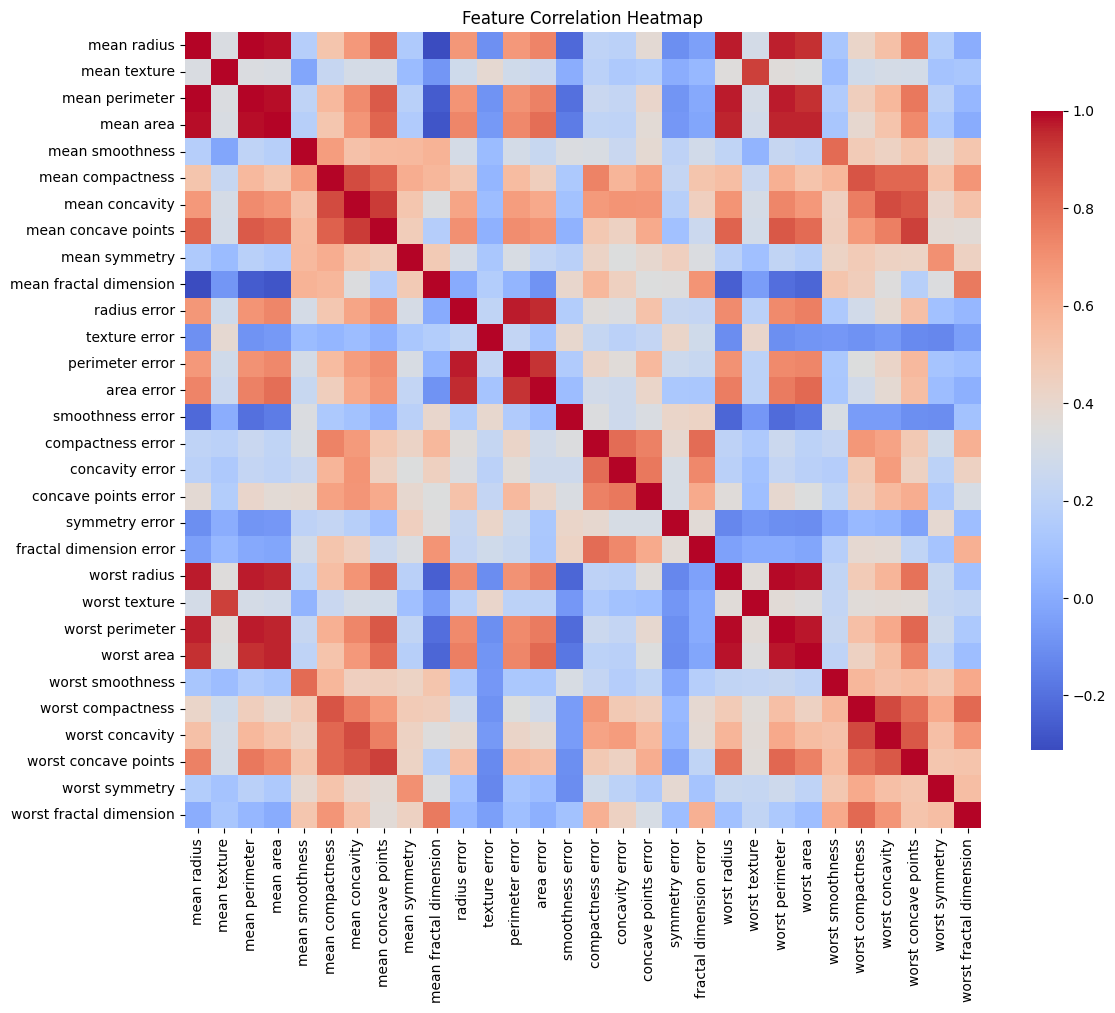

In [ ]:
# --- Correlation Matrix Heatmap ---
plt.figure(figsize=(12, 10))
corr = df[data.feature_names].corr()
sns.heatmap(corr, cmap='coolwarm', annot=False, square=True, cbar_kws={"shrink": .8})
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

** Remarks **

- The clusters of high correlations are variables naturally related to each other(such as measurement of radius, perimeter, area). But this was a good reminder that our final choice of variables should not be highly correlated with each other to avoid multicollinearity.

# 2.3 - Visualization of selected attributes

- Based on the visualization against diagnosis and the correlation matrix, we chose the following:
    - mean radius 
    - mean perimeter
    - mean area
    - mean concavity 

to proceed as they exhibited clear differences between the diagnosis. Note that raduis, perimeter, and area are direct transformations of each other, but this not as big of an issue as it was in Logistic Regression where we only had one attribute. Here we will be performing PCA to reduce the dimentionality of the multiple attributes, through which multicolinearity naturally gets reduced.

- we will now plot the selected features. Since there were multiple, we will be using PCA to reduce it into a 2D plot. Specifically, we want to see how seperateble it is by feature

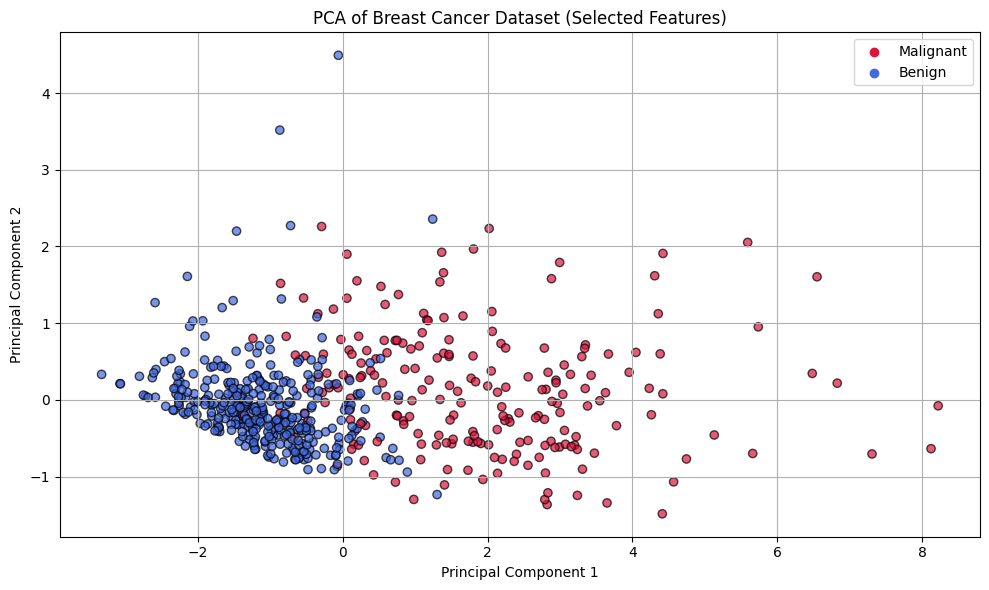

In [4]:
from sklearn.decomposition import PCA

# Select relevant features
selected_features = ['mean radius', 'mean perimeter', 'mean area', 'mean concavity']
X_selected = df[selected_features]
y = df['Diagnosis']

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_selected)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot PCA
plt.figure(figsize=(10, 6))
colors = {'Malignant': 'crimson', 'Benign': 'royalblue'}
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.map(colors), edgecolor='k', alpha=0.7)

plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Breast Cancer Dataset (Selected Features)')
for label in colors:
    plt.scatter([], [], c=colors[label], label=label)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


** Remarks **

- the two diagnosis looks seperable from this plot, especially with benign cases cluster together.

- note that there is a bit of overlapse around PC1 = 0, but we will still proceed as most of the dataset is indeed seperatble

# 3 - Defining helper functions for KNN implementation

- We will now proceed to implementing the K Nearest Neighbor algorithm on the filtered dataset. First we will define some helper functions:

    - Distance; which returns the Euclidean distance between two points

    - k_nearest_neighbors; identifies the k nearest neighbors to a given point from the training_features. It computes the distance from the point to every feature in the training set, stores the distance along with the corresponding label, and sorts the neighbors based on distance. It returns the k closest neighbors.

    - KKN_Predict; predicts the label for a given point using the K Nearest Neighbors algorithm as we defined befre. It calls k_nearest_neighbors to get the k nearest neighbors, then classifies the point based on the majority label of the neighbors (for classification) or averages the labels (for regression).

    - Classification Error; computes the classification error rate by comparing the predictions for the test set to the actual test labels. It uses the KNN_Predict function to classify each test point, and calculates the proportion of misclassified points.

In [ ]:
def distance(p, q):
    return np.sqrt((p - q) @ (p - q))

def k_nearest_neighbors(point, 
                        training_features, 
                        training_labels, 
                        k):
    # Create an empty list to store neighbors and distances
    neighbors = []
    
    for p, label in zip(training_features, training_labels):
        d = distance(point, p)
        temp_data = [p, label, d]
        neighbors.append(temp_data)
        
    neighbors.sort(key = lambda x : x[-1])
    
    return neighbors[:k]


def KNN_Predict(point, 
                training_features, 
                training_labels, 
                k, 
                regression = False):
    
    neighbors = k_nearest_neighbors(point, 
                                    training_features, 
                                    training_labels, 
                                    k)
    
    if regression == False:
        labels = [x[1] for x in neighbors]
        return max(labels, key = labels.count)
    
    else:
        return sum(x[1] for x in neighbors)/k
    
def classification_error(test_features, 
                         test_labels,
                         training_features, 
                         training_labels,
                         k):
    error = 0
    for point, label in zip(test_features, test_labels):
        error += label != KNN_Predict(point, 
                                      training_features, 
                                      training_labels, 
                                      k)
    return error/len(test_features)


# 4 - Implementing KKN Model

- Now we are ready to implement the KKN algorithm on the selected attributes and use it to make predictions. 

- We will split the dataset as usual, and perform KKN analysis using functions defined above

In [8]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# --- Apply KNN on the Data ---
k = 5  # Choose k, you can experiment with different values of k

# Make predictions on the test set
predictions = [KNN_Predict(point, X_train, y_train, k) for point in X_test]

# --- Calculate Classification Error ---
error = classification_error(X_test, y_test, X_train, y_train, k)
print(f"Classification Error for k={k}: {error}")

Classification Error for k=5: 0.07017543859649122


** Remarks **

- Looks like a pretty reasonable model! our classification error was ~7% with a K = 5, meaning the model labled diagnosis correctly most of the times. 

- We do note that the K was chosen more or less arbitrarily, so later on we will try on different values of K over a range to try to estimate the optimal value to use. 

- For now, we will print out more metrics for this model and visualize its results

# 5 - Visualize model results and confusion matrix

- Here we output a plot summarizing the correct and incorrect classifications made by the model, and also a confusion matrix. We hope to gauge the prediction power of our model and identify any biases against certain diagnosis if it exists.

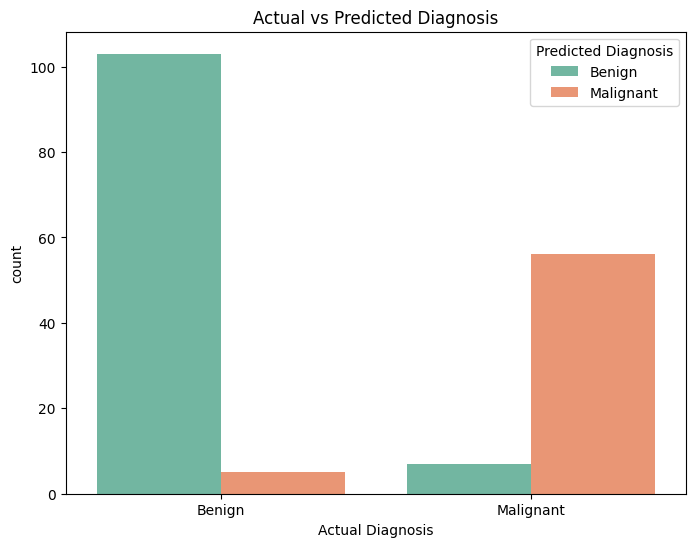

In [14]:
import seaborn as sns

# Count plot of actual vs predicted diagnoses
plt.figure(figsize=(8, 6))
sns.countplot(x="Actual Diagnosis", hue="Predicted Diagnosis", data=comparison_df, palette="Set2")
plt.title('Actual vs Predicted Diagnosis')
plt.show()


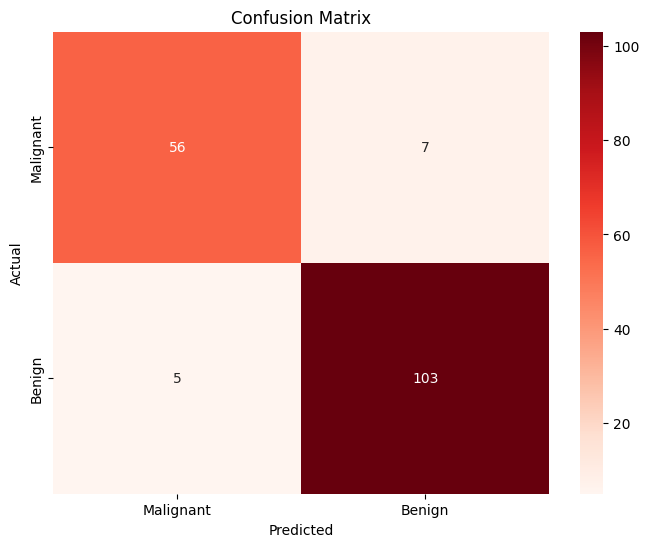

In [13]:
# Generate the confusion matrix
cm = confusion_matrix(y_test, predictions, labels=['Malignant', 'Benign'])

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Reds", xticklabels=['Malignant', 'Benign'], yticklabels=['Malignant', 'Benign'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

** Remarks **

- together with the 0.07 classification error calculated before, we can say that the model is quite accurate in predicting diagnosis, albiet with a slight bias towards false negatives(which would be horrific in our dataset's contect)

- as mentioned before, the K has been chosen arbitrarily, so we would now iterate through the same process with different values of K to see if we can find a better performing value for K.

# 6 - Testing for optimal values of K

- We implement different KKN models with values of K from 1 to 20

- We will calculate the classification error for each and plot them against the K value used, ooking for the value of K where the classification error is lowest.

- We will also output the exact error values of the 3 lowest. 

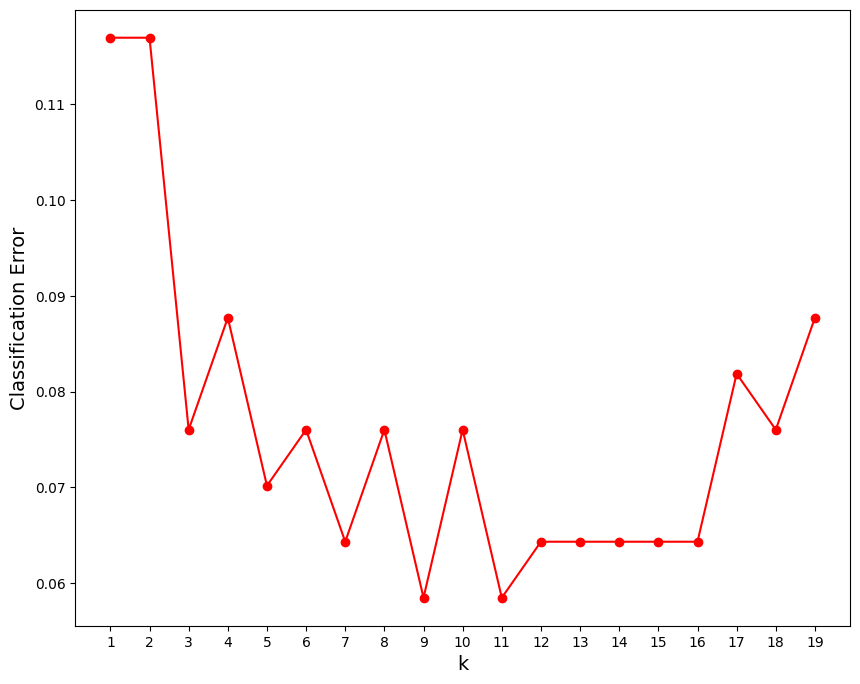

Top 3 k values with the lowest classification error:
 k  Classification Error
 9              0.058480
11              0.058480
16              0.064327


In [ ]:
possible_k = [k for k in range(1, 20, 1)]
errors = [classification_error(X_test,
                               y_test,
                               X_train,
                               y_train, k) for k in possible_k]


plt.figure(figsize = (10, 8))
plt.plot(possible_k, errors, color = 'red', marker = "o")
plt.xlabel('k', fontsize = 14)
plt.ylabel('Classification Error', fontsize = 14)
plt.xticks(possible_k)
plt.show()

# --- Find and print top 3 k-values with lowest error ---
error_summary = pd.DataFrame({'k': possible_k, 'Classification Error': errors})
top_3 = error_summary.sort_values(by='Classification Error').head(3)
print("Top 3 k values with the lowest classification error:")
print(top_3.to_string(index=False))

** Remarks **

- Seems like K = 9 was the most optimal in this case, with the lowest classification error of 0.058 compared to K = 5's 0.7. We also see a trend in the plot with error decreasing for K = 1 - 11, then bouncing back and stablizing for K=12 to 16, and finally climbing up.

# 7 - Comparison with Logistic Regression

- since we we reused the same dataset as logistic regression, it will be of great interest to cpompare various aspects of the two models and their performance:

- Performance:

KKN: 
Classification Error: 0.058480

Logistic:
Model Accuracy: 0.8947
Model F1 Score: 0.9167

Classification Report:

               precision    recall  f1-score   support

     Malignant (0)       0.86      0.86      0.86        63
     Benign (1)       0.92      0.92      0.92       108

     accuracy                           0.89       171
    macro avg       0.89      0.89      0.89       171

KNN performed slightly better in terms of classification error (5.85%) compared to Logistic Regression (10.53%). This suggests KNN captured local structures in the data more effectively, likely aided by PCA and selected features. We also note that multiple attributes were used for KKN as opposed to Logistics' one.

Logistic Regression, while having slightly lower accuracy, offers much better interpretability and model diagnostics (e.g., F1-score, coefficients).

KNN's non-parametric nature allows it to perform better when the data is not linearly separable, but it comes at the cost of higher computational expense during prediction.

Logistic Regression achieved a high F1-score of 0.9167 for the Benign class, indicating solid performance in precision-recall tradeoff—essential in medical contexts

# Conclusion

- Overall, the KNN model was able to achieve accurate predictions and diagnosis.

- Important insights into chossing between KNN and Logistic:

- Use KNN when:

    - we suspect complex, non-linear class boundaries, have enough computation time at inference, or when interpretability is not a priority.

- Use Logistic Regression when:

    - interpretability and speed are needed, relationships are expected to be linear, or we want a probabilistic view of predictions.